# import utils py



In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
from sklearn.exceptions import UndefinedMetricWarning

# Suppress just this warning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

def plot_history(r):
    plt.figure(figsize=(12, 16))

    plt.subplot(4, 2, 1)
    plt.plot(r.history['loss'], label='Loss')
    plt.plot(r.history['val_loss'], label='val_Loss')
    plt.title('Loss Function Evolution')
    plt.legend()

    plt.subplot(4, 2, 2)
    plt.plot(r.history['accuracy'], label='accuracy')
    plt.plot(r.history['val_accuracy'], label='val_accuracy')
    plt.title('Accuracy Function Evolution')
    plt.legend()

    plt.subplot(4, 2, 3)
    plt.plot(r.history['precision'], label='precision')
    plt.plot(r.history['val_precision'], label='val_precision')
    plt.title('Precision Function Evolution')
    plt.legend()

    plt.subplot(4, 2, 4)
    plt.plot(r.history['recall'], label='recall')
    plt.plot(r.history['val_recall'], label='val_recall')
    plt.title('Recall Function Evolution')
    plt.legend()

def display_conf(model,X_val, y_val):
    evaluation = model.evaluate(X_val, y_val)
    print(f'Test Accuracy : {evaluation[1] * 100:.2f}%')

    y_pred = model.predict(X_val)
    # y_pred = np.argmax(y_pred, axis=1) # Remove or comment out this line
    cm = confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1)) # Change y_test to np.argmax(y_test, axis=1)

    # Get the unique labels from the confusion matrix

    display_classification_report(y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=['angry', 'fear', 'happy', 'sad'])


    # NOTE: Fill all variables here with default values of the plot_confusion_matrix
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = disp.plot(xticks_rotation='vertical', ax=ax,cmap='summer')

    plt.show()
from sklearn.metrics import classification_report

def display_classification_report(y_true, y_pred):
    # Convert one-hot encoded labels back to original labels
    y_true_labels = np.argmax(y_true, axis=1)
    y_pred_labels = np.argmax(y_pred, axis=1)

    # Generate the classification report
    report = classification_report(y_true_labels, y_pred_labels, target_names=['angry', 'fear', 'happy', 'sad'])

    # Print the classification report
    print(report)

def save_mel_spectrogram_as_image(log_spectrogram, sr, output_filename,size):
    """Saves a log mel spectrogram as a 128x128 pixel image."""

    # Set DPI and figsize such that: DPI * figsize = 128 pixels
    dpi = 200
    fig_size = (size / dpi, size / dpi)  # (width, height) in inches

    fig, ax = plt.subplots(figsize=fig_size, dpi=dpi)
    librosa.display.specshow(log_spectrogram, sr=sr, ax=ax, x_axis=None, y_axis=None)

    # Remove axis ticks and labels
    ax.set_axis_off()

    # Save the figure
    fig.savefig(output_filename, bbox_inches='tight', pad_inches=0)
    plt.close(fig)

def load_crema_dataset(path_cremad):
    """
    Loads the CREMA-D dataset from the specified path, extracting emotion labels and file paths.

    Parameters:
        path_cremad (str): Base directory path where the CREMA-D dataset is stored.

    Returns:
        pd.DataFrame: A DataFrame with two columns: 'Emotions' and 'Path'
    """
    crema_directory = os.path.join(path_cremad, 'AudioWAV')
    crema_directory_list = os.listdir(crema_directory)

    file_emotion = []
    file_path = []

    for file in crema_directory_list:
        if file.endswith(".wav"):
            file_path.append(os.path.join(crema_directory, file))
            part = file.split('_')
            try:
                emotion_code = part[2]
                emotion = {
                    'SAD': 'sad',
                    'ANG': 'angry',
                    'DIS': 'disgust',
                    'FEA': 'fear',
                    'HAP': 'happy',
                    'NEU': 'neutral'
                }.get(emotion_code, 'Unknown')
                file_emotion.append(emotion)
            except IndexError:
                file_emotion.append('Unknown')
                print(f"Warning: Unexpected filename format: {file}")

    emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
    path_df = pd.DataFrame(file_path, columns=['Path'])
    Crema_df = pd.concat([emotion_df, path_df], axis=1)

    return Crema_df


def load_savee_dataset(path_savee):
    """
    Loads the SAVEE dataset from the specified path, extracting emotion labels and file paths.

    Parameters:
        path_savee (str): Base directory path where the SAVEE dataset is stored.

    Returns:
        pd.DataFrame: A DataFrame with two columns: 'Emotions' and 'Path'
    """
    savee_directory = os.path.join(path_savee, 'ALL')
    savee_directory_list = os.listdir(savee_directory)

    file_emotion = []
    file_path = []

    for file in savee_directory_list:
        full_path = os.path.join(savee_directory, file)
        file_path.append(full_path)

        try:
            part = file.split('_')[1]
            ele = part[:-6]  # remove the speaker ID and file extension part
            emotion = {
                'a': 'angry',
                'd': 'disgust',
                'f': 'fear',
                'h': 'happy',
                'n': 'neutral',
                'sa': 'sad'
            }.get(ele, 'surprise')
            file_emotion.append(emotion)
        except IndexError:
            file_emotion.append('Unknown')
            print(f"Warning: Unexpected filename format: {file}")

    emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
    path_df = pd.DataFrame(file_path, columns=['Path'])
    Savee_df = pd.concat([emotion_df, path_df], axis=1)

    return Savee_df

def load_tess_dataset(path_tess):
    """
    Loads the TESS dataset from the specified path, extracting emotion labels and file paths.

    Parameters:
        path_tess (str): Base directory path where the TESS dataset is stored.

    Returns:
        pd.DataFrame: A DataFrame with two columns: 'Emotions' and 'Path'
    """
    base_dir = os.path.join(path_tess, 'tess toronto emotional speech set data', 'TESS Toronto emotional speech set data')
    tess_directory_list = os.listdir(base_dir)

    file_emotion = []
    file_path = []

    for dir in tess_directory_list:
        full_dir_path = os.path.join(base_dir, dir)
        try:
            directories = os.listdir(full_dir_path)
        except NotADirectoryError:
            print(f"Warning: {full_dir_path} is not a directory, skipping.")
            continue

        for file in directories:
            try:
                part = file.split('.')[0].split('_')[2]
                emotion = 'surprise' if part == 'ps' else part
                file_emotion.append(emotion)
                file_path.append(os.path.join(full_dir_path, file))
            except IndexError:
                print(f"Warning: Unexpected filename format: {file}")
                file_emotion.append('Unknown')
                file_path.append(os.path.join(full_dir_path, file))

    emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
    path_df = pd.DataFrame(file_path, columns=['Path'])
    Tess_df = pd.concat([emotion_df, path_df], axis=1)

    return Tess_df


from keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, SeparableConv2D, Layer
from keras.layers import Conv2D, Layer,MaxPooling2D
from keras.layers import Flatten, Dense
# Code for Adapted CNN Model
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Concatenate, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
def build_adapted_cnn(input_shape=(77, 77, 3), num_classes=4): # Defaulting to 7 classes, adjust as needed
    input_tensor = Input(shape=input_shape, name='input_spectrogram')

    # Branch 1
    x1 = Conv2D(64, (9, 9), activation='relu', padding='same', name='conv1')(input_tensor)
    # The original diagram and text indicate a Max Pooling output of 20x32 for each branch
    # from a 256x256 input. Achieving this specific dimension from the new (77,77)
    # input with standard MaxPooling2D is challenging without more details on original
    # padding/strides or using adaptive pooling layers (e.g., tf.image.resize followed by pool).
    # For this adaptation, we'll use a pooling strategy that significantly reduces dimensions
    # to create a manageable feature vector size for the fully connected layers.
    # Here, we aim for a spatial output of approximately (5,5) from each pooling layer.
    # For a 77x77 input to pooling, pool_size=(15,15) with strides=(15,15) yields (5,5):
    # H_out = floor((77-15)/15)+1 = 5
    x1 = MaxPooling2D(pool_size=(15, 15), strides=(15, 15), name='pool1')(x1) # Output: (5,5,64)

    # Branch 2
    x2 = Conv2D(120, (7, 7), activation='relu', padding='same', name='conv2')(input_tensor)
    x2 = MaxPooling2D(pool_size=(15, 15), strides=(15, 15), name='pool2')(x2) # Output: (5,5,120)

    # Branch 3
    x3 = Conv2D(200, (3, 3), activation='relu', padding='same', name='conv3')(input_tensor)
    x3 = MaxPooling2D(pool_size=(15, 15), strides=(15, 15), name='pool3')(x3) # Output: (5,5,200)

    # Merge the branches
    # The outputs (5,5,64), (5,5,120), (5,5,200) are concatenated along the channel axis.
    merged = Concatenate(axis=-1, name='concatenate')([x1, x2, x3]) # Output: (5,5,384)

    # Flatten
    flattened = Flatten(name='flatten')(merged) # Output: 5*5*384 = 9600 features

    # Fully Connected Layers
    # FC1 with 256 neurons
    fc1 = Dense(256, activation='relu', name='fc1',kernel_regularizer=l2(0.001))(flattened)
    # Dropout of 25% after FC1
    fc1_dropout = Dropout(0.25, name='dropout_fc1')(fc1)

    # FC2 with 512 neurons
    # The text states "Only FC1 is followed by the dropout layer".
    fc2 = Dense(512, activation='relu', name='fc2',kernel_regularizer=l2(0.001))(fc1_dropout)

    # Output Layer
    # Classification task performed by the SoftMax unit.
    output_layer = Dense(num_classes, activation='softmax', name='softmax_output')(fc2)

    model = Model(inputs=input_tensor, outputs=output_layer, name='adapted_speech_emotion_cnn')
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')])
    return model
def create_3layer_separable_conv_model(no_filter,input_shape,filter_size,no_classes):
    model = Sequential()#32,54,128
    model.add(SeparableConv2D(no_filter[0], kernel_size=filter_size, activation='relu', input_shape=input_shape))
    model.add(PrintLayerShape())  # Print shape after first layer
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(SeparableConv2D(no_filter[1], kernel_size=filter_size, activation='relu'))
    model.add(PrintLayerShape())  # Print shape after second layer
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(SeparableConv2D(no_filter[2], kernel_size=filter_size, activation='relu', strides=(2, 2)))
    model.add(PrintLayerShape())  # Print shape after third layer
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(no_classes, activation='softmax'))
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')])
    print(model.summary())
    return model

def create_3layer_model(layer_size,input_shape,filter_size):
    model = Sequential()
    model.add(Conv2D(layer_size[0], (filter_size, filter_size), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(layer_size[1],(filter_size, filter_size), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(layer_size[2], (filter_size, filter_size), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')])
    print(model.summary())
    return model

import tensorflow as tf
from tensorflow.keras import layers, models


from tensorflow.keras.layers import MaxPooling2D
import tensorflow as tf

def create_dscnn_model(input_shape):
    model = models.Sequential()

    # 1st Convolutional Layer
    model.add(layers.Conv2D(32, (11, 11), strides=(2, 2), padding='same',
                            activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(2, 2))

    # 2nd Convolutional Layer
    model.add(layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same',
                            activation='relu'))
    model.add(MaxPooling2D(2, 2))

    # 3rd Convolutional Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(1, 1), padding='same',
                            activation='relu'))
    model.add(MaxPooling2D(2, 2))

    # 4th Convolutional Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(1, 1), padding='same',
                            activation='relu'))
    model.add(MaxPooling2D(2, 2))

    # 5th Convolutional Layer
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same',
                            activation='relu'))

    # ⚠️ Removed final MaxPooling2D to avoid negative spatial dimensions
    # model.add(MaxPooling2D(2, 2))

    # Flatten and Fully Connected Layers
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dropout(0.5))

    # Output layer with SoftMax activation
    model.add(layers.Dense(4, activation='softmax'))
    print(model.summary())

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )
    return model

class PrintLayerShape(Layer):
    def call(self, inputs):
        print(inputs.shape)
        return inputs

def create_3layer_model_with_augmentation(layer_size, input_shape, filter_size, target_size=(128, 128)):
    """
    Creates a 3-layer CNN model with data augmentation layers.

    Args:
        layer_size (list): List of 3 integers specifying the number of filters for each conv layer
        input_shape (tuple): Input shape of the images (height, width, channels)
        filter_size (int): Size of the convolutional filters
        target_size (tuple): Target size for resizing images (default: 128x128)
    """
    # Create a Sequential model starting with augmentation layers
    model = Sequential([
        # First augmentation layer: Resize and Rescale
        tf.keras.layers.Resizing(
            target_size[0], target_size[1],
            interpolation='bilinear',
            name='resize_layer'
        ),

        # Second augmentation layer: Random rotation and flip
        tf.keras.layers.RandomRotation(
            0.2,  # Rotate up to 20% of a full circle
            fill_mode='nearest',
            name='random_rotation'
        ),
        tf.keras.layers.RandomFlip(
            mode='horizontal',  # Random horizontal flips
            name='random_flip'
        ),

        # Original CNN layers
        Conv2D(layer_size[0], (filter_size, filter_size), activation='relu', input_shape=input_shape),
        MaxPooling2D(2, 2),
        Conv2D(layer_size[1], (filter_size, filter_size), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(layer_size[2], (filter_size, filter_size), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(1024, activation='relu'),
        Dense(4, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )
    print(model.summary())
    return model

In [ ]:


def weighted_categorical_crossentropy(class_weights):
    """
    Custom loss function that applies higher weights to specific classes.

    Args:
        class_weights (dict): Dictionary mapping class indices to their weights
                             e.g., {0: 1.0, 1: 2.0, 2: 2.0, 3: 1.0}
                             where 1=fear and 2=happy get higher weights
    """
    def loss(y_true, y_pred):
        # Convert class weights to a tensor
        weights = tf.constant([class_weights[i] for i in range(len(class_weights))])
        # Expand weights to match batch size
        weights = tf.expand_dims(weights, 0)
        weights = tf.tile(weights, [tf.shape(y_true)[0], 1])

        # Calculate weighted categorical crossentropy
        cce = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        weighted_cce = cce * tf.reduce_sum(weights * y_true, axis=1)
        return tf.reduce_mean(weighted_cce)

    return loss

def build_adapted_cnn_with_augmentation_weighted(input_shape=(77, 77, 3), num_classes=4, target_size=(128, 128)):
    """
    Builds the adapted CNN model with data augmentation layers and weighted loss function.
    Gives higher weights to 'fear' and 'happy' classes to improve their prediction.

    Args:
        input_shape (tuple): Input shape of the images (height, width, channels)
        num_classes (int): Number of output classes
        target_size (tuple): Target size for resizing images (default: 128x128)
    """
    # Input layer
    input_tensor = Input(shape=input_shape, name='input_spectrogram')

    # Augmentation layers
    x = tf.keras.layers.Resizing(
        target_size[0], target_size[1],
        interpolation='bilinear',
        name='resize_layer'
    )(input_tensor)

    x = tf.keras.layers.RandomRotation(
        0.2,
        fill_mode='nearest',
        name='random_rotation'
    )(x)

    x = tf.keras.layers.RandomFlip(
        mode='horizontal',
        name='random_flip'
    )(x)

    # Branch 1
    x1 = Conv2D(64, (9, 9), activation='relu', padding='same', name='conv1')(x)
    x1 = MaxPooling2D(pool_size=(15, 15), strides=(15, 15), name='pool1')(x1)

    # Branch 2
    x2 = Conv2D(120, (7, 7), activation='relu', padding='same', name='conv2')(x)
    x2 = MaxPooling2D(pool_size=(15, 15), strides=(15, 15), name='pool2')(x2)

    # Branch 3
    x3 = Conv2D(200, (3, 3), activation='relu', padding='same', name='conv3')(x)
    x3 = MaxPooling2D(pool_size=(15, 15), strides=(15, 15), name='pool3')(x3)

    # Merge the branches
    merged = Concatenate(axis=-1, name='concatenate')([x1, x2, x3])

    # Flatten
    flattened = Flatten(name='flatten')(merged)

    # Fully Connected Layers with increased dropout for better regularization
    fc1 = Dense(256, activation='relu', name='fc1', kernel_regularizer=l2(0.001))(flattened)
    fc1_dropout = Dropout(0.35, name='dropout_fc1')(fc1)  # Increased dropout

    fc2 = Dense(512, activation='relu', name='fc2', kernel_regularizer=l2(0.001))(fc1_dropout)
    fc2_dropout = Dropout(0.35, name='dropout_fc2')(fc2)  # Added dropout to second FC layer

    # Output Layer
    output_layer = Dense(num_classes, activation='softmax', name='softmax_output')(fc2_dropout)

    model = Model(inputs=input_tensor, outputs=output_layer, name='adapted_speech_emotion_cnn_weighted')

    # Define class weights (higher for fear and happy)
    class_weights = {
        0: 1.0,  # angry
        1: 2.0,  # fear (increased weight)
        2: 1.5,  # happy (increased weight)
        3: 1.0   # sad
    }

    model.compile(
        loss=weighted_categorical_crossentropy(class_weights),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),  # Slightly lower learning rate
        metrics=['accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )
    return model



In [ ]:


def build_adapted_cnn_with_augmentation(input_shape=(77, 77, 3), num_classes=4, target_size=(128, 128)):
    """
    Builds the adapted CNN model with data augmentation layers.

    Args:
        input_shape (tuple): Input shape of the images (height, width, channels)
        num_classes (int): Number of output classes
        target_size (tuple): Target size for resizing images (default: 128x128)
    """
    # Input layer
    input_tensor = Input(shape=input_shape, name='input_spectrogram')

    # Augmentation layers
    x = tf.keras.layers.Resizing(
        target_size[0], target_size[1],
        interpolation='bilinear',
        name='resize_layer'
    )(input_tensor)

    x = tf.keras.layers.RandomRotation(
        0.2,  # Rotate up to 20% of a full circle
        fill_mode='nearest',
        name='random_rotation'
    )(x)

    x = tf.keras.layers.RandomFlip(
        mode='horizontal',  # Random horizontal flips
        name='random_flip'
    )(x)

    # Branch 1
    x1 = Conv2D(64, (9, 9), activation='relu', padding='same', name='conv1')(x)
    x1 = MaxPooling2D(pool_size=(15, 15), strides=(15, 15), name='pool1')(x1)

    # Branch 2
    x2 = Conv2D(120, (7, 7), activation='relu', padding='same', name='conv2')(x)
    x2 = MaxPooling2D(pool_size=(15, 15), strides=(15, 15), name='pool2')(x2)

    # Branch 3
    x3 = Conv2D(200, (3, 3), activation='relu', padding='same', name='conv3')(x)
    x3 = MaxPooling2D(pool_size=(15, 15), strides=(15, 15), name='pool3')(x3)

    # Merge the branches
    merged = Concatenate(axis=-1, name='concatenate')([x1, x2, x3])

    # Flatten
    flattened = Flatten(name='flatten')(merged)

    # Fully Connected Layers
    fc1 = Dense(256, activation='relu', name='fc1', kernel_regularizer=l2(0.001))(flattened)
    fc1_dropout = Dropout(0.25, name='dropout_fc1')(fc1)

    fc2 = Dense(512, activation='relu', name='fc2', kernel_regularizer=l2(0.001))(fc1_dropout)

    # Output Layer
    output_layer = Dense(num_classes, activation='softmax', name='softmax_output')(fc2)

    model = Model(inputs=input_tensor, outputs=output_layer, name='adapted_speech_emotion_cnn_with_aug')
    model.compile(
        loss=tf.keras.losses.categorical_crossentropy,
        optimizer=tf.keras.optimizers.Adam(),
        metrics=['accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )
    return model



# import files etc

In [ ]:
!pip install patool

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.5/86.5 kB 2.7 MB/s eta 0:00:00


In [42]:
print('1')

1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import patoolib

patoolib.extract_archive("/content/drive/MyDrive/dataset.rar", outdir="/content/dataset")

INFO patool: Extracting /content/drive/MyDrive/dataset.rar ...
INFO:patool:Extracting /content/drive/MyDrive/dataset.rar ...
INFO patool: ... creating output directory `/content/dataset'.
INFO:patool:... creating output directory `/content/dataset'.
INFO patool: running /usr/bin/unrar x -kb -or -- /content/drive/MyDrive/dataset.rar
INFO:patool:running /usr/bin/unrar x -kb -or -- /content/drive/MyDrive/dataset.rar
INFO patool: ... /content/drive/MyDrive/dataset.rar extracted to `/content/dataset'.
INFO:patool:... /content/drive/MyDrive/dataset.rar extracted to `/content/dataset'.


'/content/dataset'

In [ ]:
import os
datapath='dataset/dataset/spectograms/'


In [ ]:
!pip install visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.4/997.4 kB 16.4 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import visualkeras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, SeparableConv2D, Layer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
class PrintLayerShape(Layer):
    def call(self, inputs):
        print(inputs.shape)
        return inputs


In [ ]:
import numpy as np
y=np.load('dataset/dataset/classes/array.npy')


In [ ]:
import cv2
X=[]
for i in range(len(os.listdir(datapath))):
    output_filename = f"{datapath}{str(i)}.png"
    img = cv2.imread(output_filename)
    if img is not None:
        X.append(img)
X=np.array(X)

In [ ]:
len(X)

6924

In [ ]:
len(y)

6924

In [ ]:
X[0].shape

(77, 77, 3)

In [ ]:
y  = to_categorical(y, num_classes=4)  # Reshape y_train

X = X/255



In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.50, random_state=42)

# simple3layer

In [ ]:
model1=create_3layer_model([64,128,128],X[0].shape,3)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 75, 75, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 35, 35, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     6,423,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,650,884 (25.37 MB)

 Trainable params: 6,650,884 (25.37 MB)

 Non-trainable params: 0 (0.00 B)

None


/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


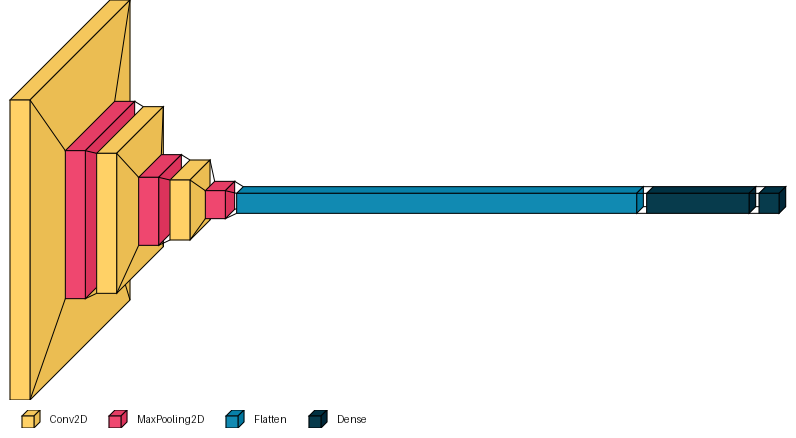

In [ ]:

visualkeras.layered_view(model1, to_file='model1_visualization.png', legend=True)

In [ ]:
r1 = model1.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test) , batch_size=32)

Epoch 1/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.3872 - loss: 1.2872 - precision: 0.4721 - recall: 0.0975 - val_accuracy: 0.4581 - val_loss: 1.1299 - val_precision: 0.6254 - val_recall: 0.2991
Epoch 2/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5070 - loss: 1.0656 - precision: 0.6309 - recall: 0.2982 - val_accuracy: 0.5983 - val_loss: 0.8918 - val_precision: 0.7047 - val_recall: 0.4725
Epoch 3/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6460 - loss: 0.8161 - precision: 0.7421 - recall: 0.5126 - val_accuracy: 0.6618 - val_loss: 0.7765 - val_precision: 0.7378 - val_recall: 0.5694
Epoch 4/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6702 - loss: 0.7352 - precision: 0.7595 - recall: 0.5641 - val_accuracy: 0.6676 - val_loss: 0.7879 - val_precision: 0.7410 - val_recall: 0.5332
Epoch 5/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6989 - loss: 0.6827 - precision: 0.7749 - recall: 0.5948 - val_accuracy: 0.6893 - val_l

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.6446 - loss: 3.7049 - precision: 0.6446 - recall: 0.6412
Test Accuracy : 65.37%
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
              precision    recall  f1-score   support

       angry       0.72      0.71      0.71       169
        fear       0.57      0.56      0.57       168
       happy       0.60      0.60      0.60       179
         sad       0.72      0.74      0.73       177

    accuracy                           0.65       693
   macro avg       0.65      0.65      0.65       693
weighted avg       0.65      0.65      0.65       693



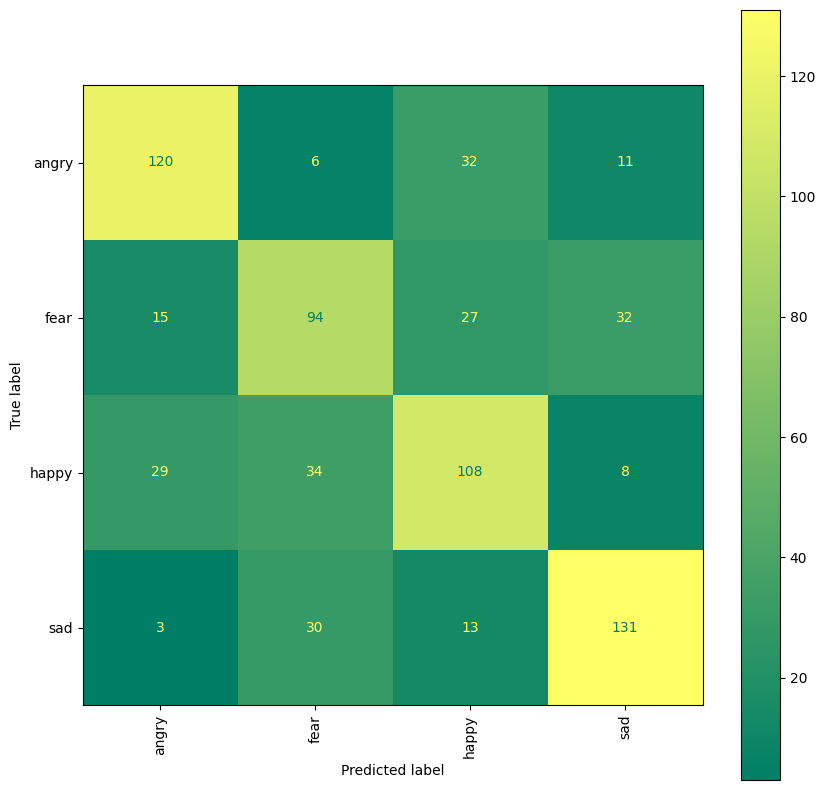

In [ ]:
display_conf(model1,X_val, y_val)#6580


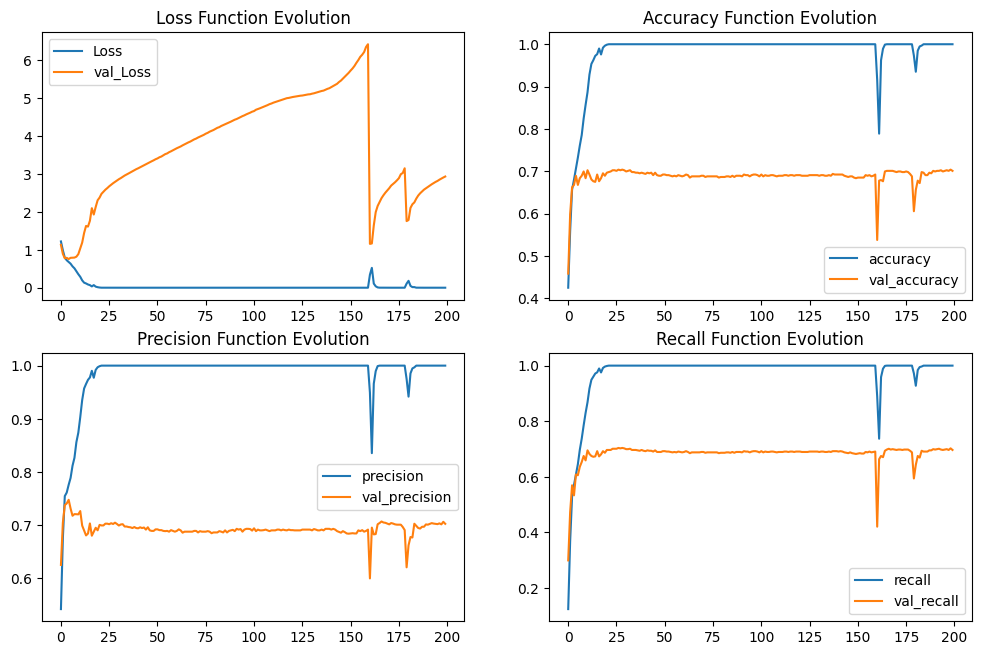

In [ ]:
plot_history(r1)

In [ ]:
model2=create_3layer_model([64,120,200],X[0].shape,3)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 75, 75, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 35, 35, 120)    │        69,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 17, 17, 120)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 15, 15, 200)    │       216,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 7, 7, 200)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9800)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │    10,036,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,327,556 (39.40 MB)

 Trainable params: 10,327,556 (39.40 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
r2 = model2.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test) , batch_size=32)

Epoch 1/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.4021 - loss: 1.2905 - precision: 0.4594 - recall: 0.1130 - val_accuracy: 0.5202 - val_loss: 1.1483 - val_precision: 0.6471 - val_recall: 0.3020
Epoch 2/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5554 - loss: 1.0118 - precision: 0.6846 - recall: 0.3672 - val_accuracy: 0.6344 - val_loss: 0.8407 - val_precision: 0.7489 - val_recall: 0.4957
Epoch 3/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6572 - loss: 0.7741 - precision: 0.7619 - recall: 0.5322 - val_accuracy: 0.6633 - val_loss: 0.7634 - val_precision: 0.7346 - val_recall: 0.5679
Epoch 4/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7045 - loss: 0.6963 - precision: 0.7774 - recall: 0.6056 - val_accuracy: 0.6734 - val_loss: 0.7556 - val_precision: 0.7443 - val_recall: 0.5679
Epoch 5/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7127 - loss: 0.6504 - precision: 0.7800 - recall: 0.6231 - val_accuracy: 0.6777 - val_lo

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6218 - loss: 8.8194 - precision: 0.6225 - recall: 0.6218
Test Accuracy : 63.35%
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
              precision    recall  f1-score   support

       angry       0.68      0.70      0.69       169
        fear       0.56      0.54      0.55       168
       happy       0.62      0.59      0.61       179
         sad       0.66      0.70      0.68       177

    accuracy                           0.63       693
   macro avg       0.63      0.63      0.63       693
weighted avg       0.63      0.63      0.63       693



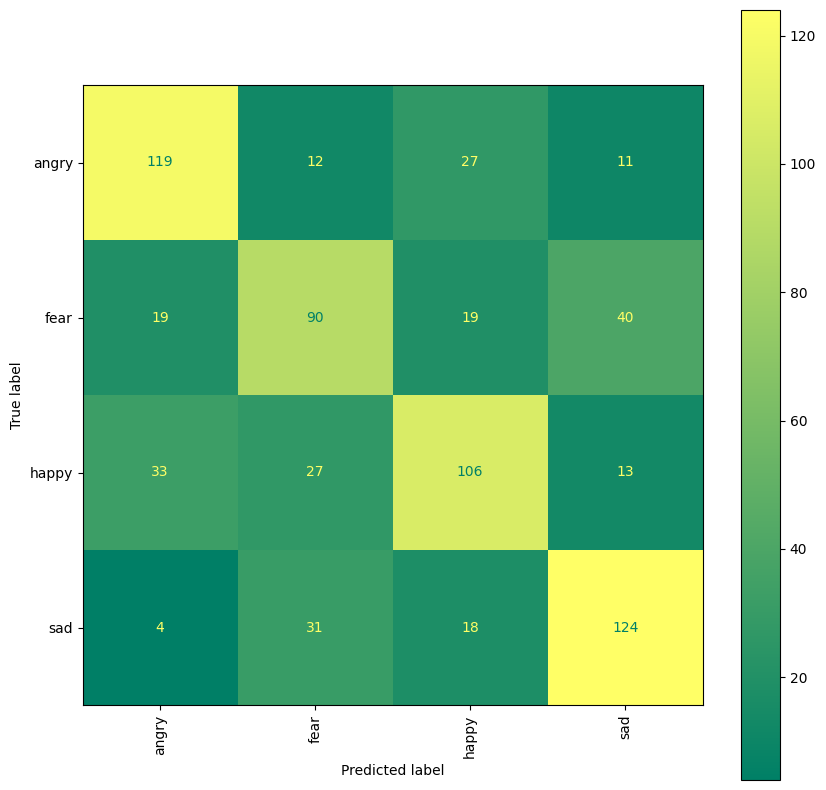

In [ ]:
display_conf(model2,X_val, y_val)


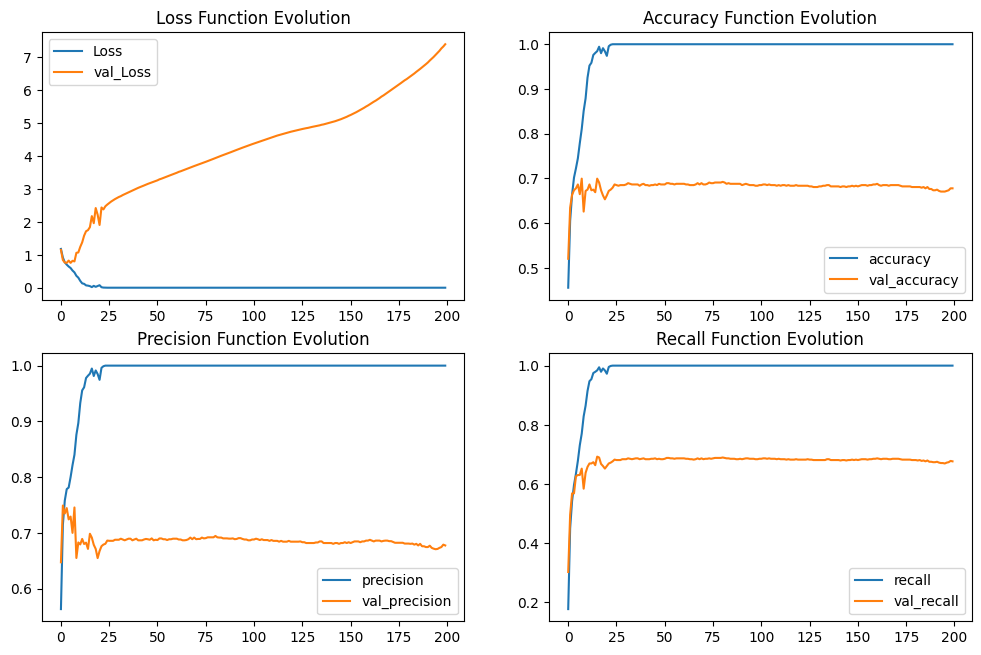

In [ ]:
plot_history(r2)

# adapted cnn

In [ ]:
model_par=build_adapted_cnn(X[0].shape,4)
visualkeras.layered_view(model_par, to_file='model_visualization.png', legend=True )
r_par=model_par.fit(X_train, y_train,
          batch_size=32,
          epochs=200,
          validation_data=(X_test, y_test),)


/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


Epoch 1/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 17s 63ms/step - accuracy: 0.3901 - loss: 1.7169 - precision: 0.4540 - recall: 0.0935 - val_accuracy: 0.5694 - val_loss: 1.1336 - val_precision: 0.7085 - val_recall: 0.3266
Epoch 2/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5664 - loss: 1.1157 - precision: 0.6765 - recall: 0.3544 - val_accuracy: 0.6084 - val_loss: 1.0107 - val_precision: 0.6699 - val_recall: 0.5043
Epoch 3/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6418 - loss: 0.9528 - precision: 0.7317 - recall: 0.4993 - val_accuracy: 0.6460 - val_loss: 0.9219 - val_precision: 0.8281 - val_recall: 0.4176
Epoch 4/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6502 - loss: 0.8906 - precision: 0.7552 - recall: 0.5239 - val_accuracy: 0.6590 - val_loss: 0.8685 - val_precision: 0.7261 - val_recall: 0.5592
Epoch 5/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6819 - loss: 0.8471 - precision: 0.7659 - recall: 0.5541 - val_accuracy: 0.6532 - val_l

22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.6697 - loss: 1.6972 - precision: 0.6753 - recall: 0.6664
Test Accuracy : 68.25%
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step
              precision    recall  f1-score   support

       angry       0.74      0.72      0.73       169
        fear       0.61      0.61      0.61       168
       happy       0.63      0.69      0.66       179
         sad       0.76      0.72      0.74       177

    accuracy                           0.68       693
   macro avg       0.69      0.68      0.68       693
weighted avg       0.69      0.68      0.68       693



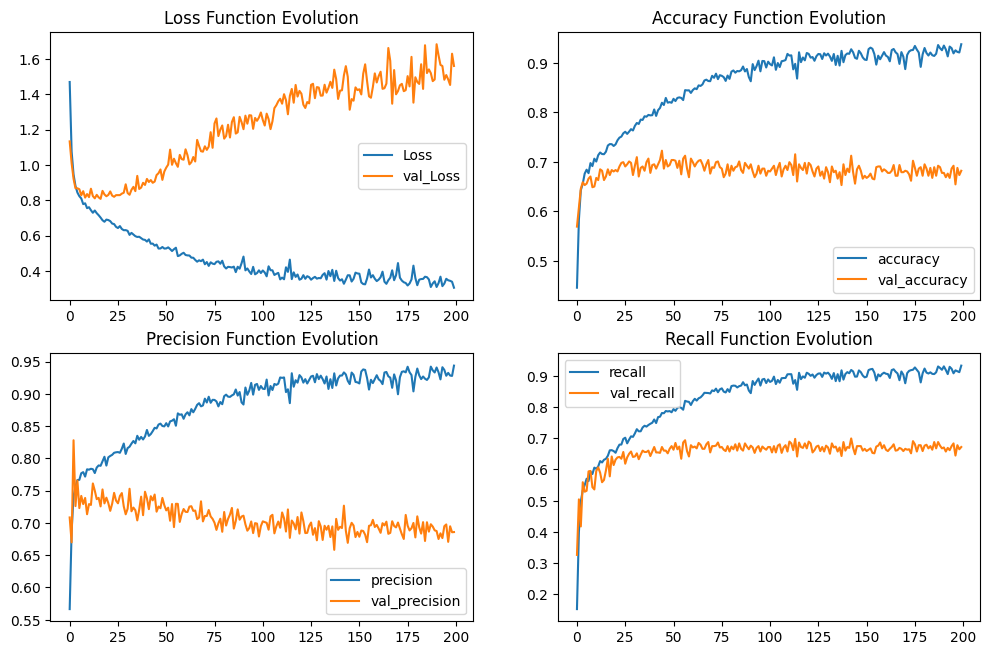

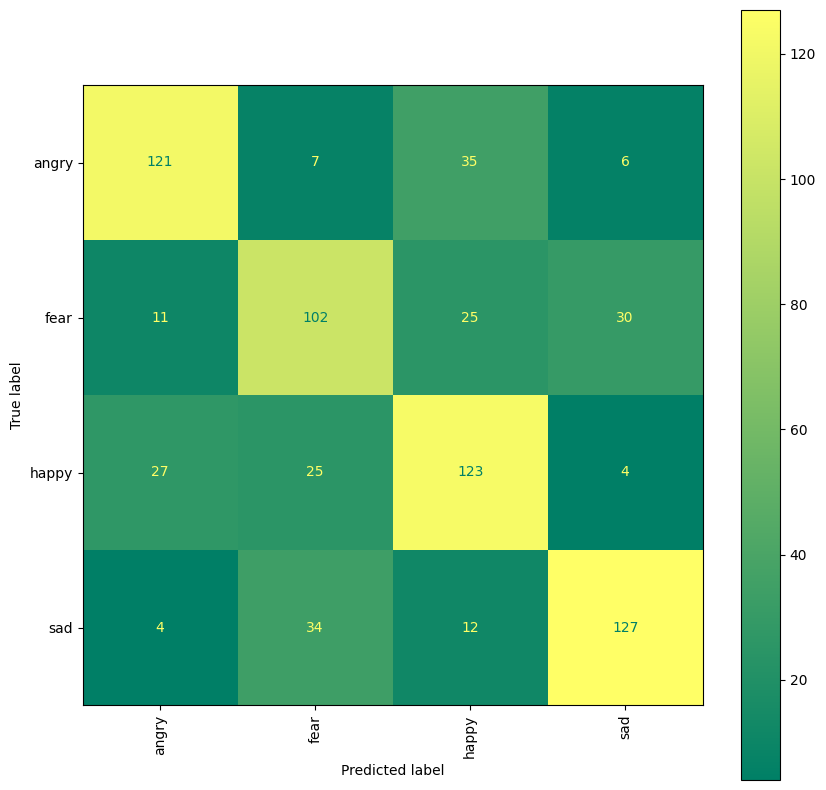

In [ ]:
plot_history(r_par)
display_conf(model_par,X_val, y_val)

# adapted cnn with augm

In [ ]:
model = build_adapted_cnn_with_augmentation(
    input_shape=(77, 77, 3),  # your input shape
    num_classes=4,            # number of output classes
    target_size=(128, 128)    # optional, defaults to 128x128
)

In [ ]:
model.build((None,) + (150, 150, 3))
visualkeras.layered_view(model , to_file='model_adapted_visualization.png', legend=True )
r_par=model .fit(X_train, y_train,
          batch_size=32,
          epochs=200,
          validation_data=(X_test, y_test),)
          #callbacks=[early_stop])


Epoch 1/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.4035 - loss: 1.7969 - precision: 0.4550 - recall: 0.0953 - val_accuracy: 0.4379 - val_loss: 1.3070 - val_precision: 0.5632 - val_recall: 0.2962
Epoch 2/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.4591 - loss: 1.2978 - precision: 0.5611 - recall: 0.2114 - val_accuracy: 0.4754 - val_loss: 1.2044 - val_precision: 0.6194 - val_recall: 0.2775
Epoch 3/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.4785 - loss: 1.2201 - precision: 0.6185 - recall: 0.2353 - val_accuracy: 0.4523 - val_loss: 1.2604 - val_precision: 0.6718 - val_recall: 0.1272
Epoch 4/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5059 - loss: 1.1799 - precision: 0.6337 - recall: 0.2607 - val_accuracy: 0.4436 - val_loss: 1.2730 - val_precision: 0.5487 - val_recall: 0.2442
Epoch 5/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5047 - loss: 1.1554 - precision: 0.6460 - recall: 0.2800 - val_accuracy: 0.5014 - va

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6149 - loss: 0.9215 - precision: 0.7386 - recall: 0.4738
Test Accuracy : 63.49%
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
              precision    recall  f1-score   support

       angry       0.68      0.72      0.70       169
        fear       0.56      0.48      0.52       168
       happy       0.58      0.56      0.57       179
         sad       0.70      0.77      0.73       177

    accuracy                           0.63       693
   macro avg       0.63      0.63      0.63       693
weighted avg       0.63      0.63      0.63       693



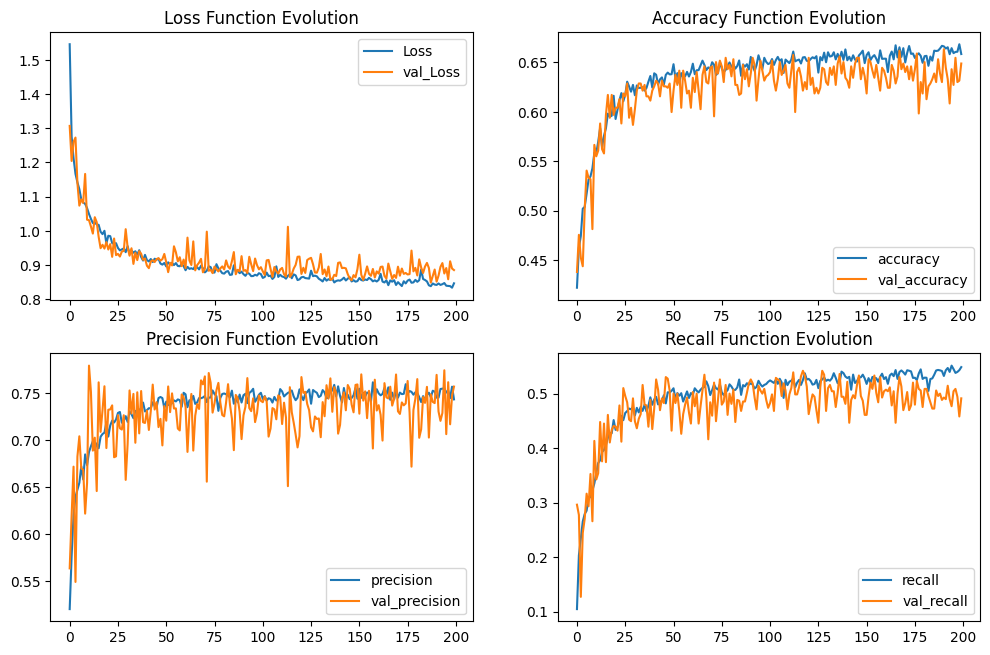

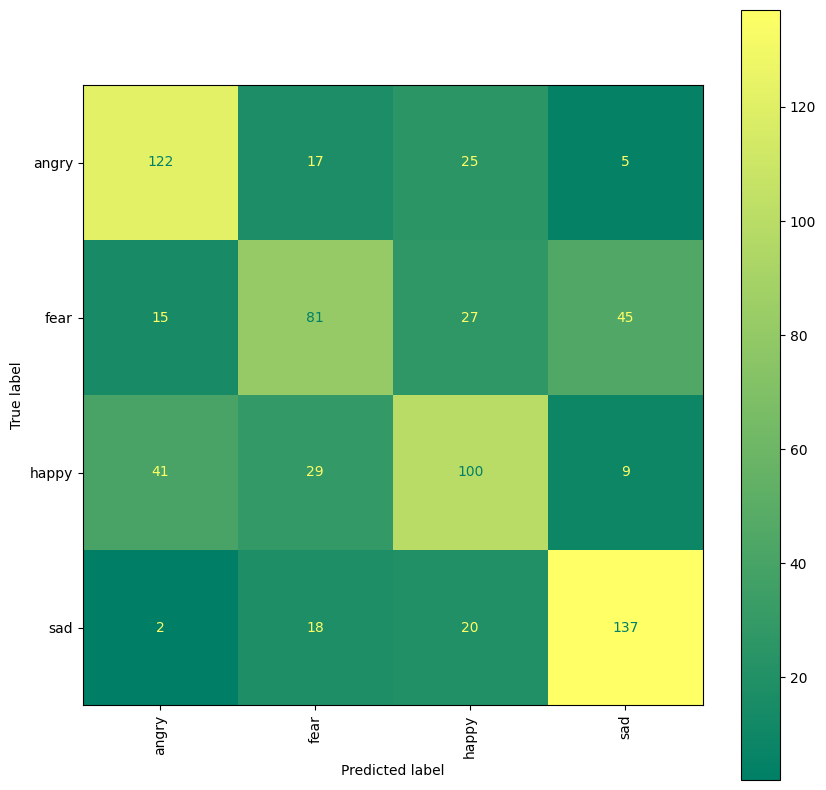

In [ ]:
plot_history(r_par)
display_conf(model,X_val, y_val)

# weighted

In [ ]:


def weighted_categorical_crossentropy(class_weights):
    """
    Custom loss function that applies higher weights to specific classes.

    Args:
        class_weights (dict): Dictionary mapping class indices to their weights
                             e.g., {0: 1.0, 1: 2.0, 2: 2.0, 3: 1.0}
                             where 1=fear and 2=happy get higher weights
    """
    def loss(y_true, y_pred):
        # Convert class weights to a tensor
        weights = tf.constant([class_weights[i] for i in range(len(class_weights))])
        # Expand weights to match batch size
        weights = tf.expand_dims(weights, 0)
        weights = tf.tile(weights, [tf.shape(y_true)[0], 1])

        # Calculate weighted categorical crossentropy
        cce = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        weighted_cce = cce * tf.reduce_sum(weights * y_true, axis=1)
        return tf.reduce_mean(weighted_cce)

    return loss

def build_adapted_cnn_with_augmentation_weighted(input_shape=(77, 77, 3), num_classes=4, target_size=(128, 128)):
    """
    Builds the adapted CNN model with data augmentation layers and weighted loss function.
    Gives higher weights to 'fear' and 'happy' classes to improve their prediction.

    Args:
        input_shape (tuple): Input shape of the images (height, width, channels)
        num_classes (int): Number of output classes
        target_size (tuple): Target size for resizing images (default: 128x128)
    """
    # Input layer
    input_tensor = Input(shape=input_shape, name='input_spectrogram')

    # Augmentation layers
    x = tf.keras.layers.Resizing(
        target_size[0], target_size[1],
        interpolation='bilinear',
        name='resize_layer'
    )(input_tensor)

    x = tf.keras.layers.RandomRotation(
        0.2,
        fill_mode='nearest',
        name='random_rotation'
    )(x)

    x = tf.keras.layers.RandomFlip(
        mode='horizontal',
        name='random_flip'
    )(x)

    # Branch 1
    x1 = Conv2D(64, (9, 9), activation='relu', padding='same', name='conv1')(x)
    x1 = MaxPooling2D(pool_size=(15, 15), strides=(15, 15), name='pool1')(x1)

    # Branch 2
    x2 = Conv2D(120, (7, 7), activation='relu', padding='same', name='conv2')(x)
    x2 = MaxPooling2D(pool_size=(15, 15), strides=(15, 15), name='pool2')(x2)

    # Branch 3
    x3 = Conv2D(200, (3, 3), activation='relu', padding='same', name='conv3')(x)
    x3 = MaxPooling2D(pool_size=(15, 15), strides=(15, 15), name='pool3')(x3)

    # Merge the branches
    merged = Concatenate(axis=-1, name='concatenate')([x1, x2, x3])

    # Flatten
    flattened = Flatten(name='flatten')(merged)

    # Fully Connected Layers with increased dropout for better regularization
    fc1 = Dense(256, activation='relu', name='fc1', kernel_regularizer=l2(0.001))(flattened)
    fc1_dropout = Dropout(0.35, name='dropout_fc1')(fc1)  # Increased dropout

    fc2 = Dense(512, activation='relu', name='fc2', kernel_regularizer=l2(0.001))(fc1_dropout)
    fc2_dropout = Dropout(0.35, name='dropout_fc2')(fc2)  # Added dropout to second FC layer

    # Output Layer
    output_layer = Dense(num_classes, activation='softmax', name='softmax_output')(fc2_dropout)

    model = Model(inputs=input_tensor, outputs=output_layer, name='adapted_speech_emotion_cnn_weighted')

    # Define class weights (higher for fear and happy)
    class_weights = {
        0: 1.0,  # angry
        1: 2.0,  # fear (increased weight)
        2: 1.5,  # happy (increased weight)
        3: 1.0   # sad
    }

    model.compile(
        loss=weighted_categorical_crossentropy(class_weights),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),  # Slightly lower learning rate
        metrics=['accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )
    return model


In [ ]:
model_w = build_adapted_cnn_with_augmentation_weighted(
    input_shape=(77, 77, 3),
    num_classes=4,
    target_size=(128, 128)
)

In [ ]:
r_w=model_w.fit(X_train, y_train,
          batch_size=32,
          epochs=200,
          validation_data=(X_test, y_test),
          verbose=1)


Epoch 1/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.3143 - loss: 2.2949 - precision: 0.3599 - recall: 0.0391 - val_accuracy: 0.2471 - val_loss: 1.8677 - val_precision: 0.3171 - val_recall: 0.0188
Epoch 2/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.3348 - loss: 1.8562 - precision: 0.4134 - recall: 0.0467 - val_accuracy: 0.4350 - val_loss: 1.7801 - val_precision: 0.6075 - val_recall: 0.1879
Epoch 3/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.3909 - loss: 1.7418 - precision: 0.5939 - recall: 0.0991 - val_accuracy: 0.4032 - val_loss: 1.6249 - val_precision: 0.7143 - val_recall: 0.1012
Epoch 4/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.4381 - loss: 1.6728 - precision: 0.6539 - recall: 0.1225 - val_accuracy: 0.4335 - val_loss: 1.6185 - val_precision: 0.6534 - val_recall: 0.1662
Epoch 5/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.4459 - loss: 1.6302 - precision: 0.5792 - recall: 0.1499 - val_accuracy: 0.5116 - va

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6407 - loss: 1.1412 - precision: 0.7387 - recall: 0.5519
Test Accuracy : 66.96%
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
              precision    recall  f1-score   support

       angry       0.80      0.70      0.74       169
        fear       0.53      0.75      0.62       168
       happy       0.63      0.70      0.66       179
         sad       0.86      0.54      0.66       177

    accuracy                           0.67       693
   macro avg       0.70      0.67      0.67       693
weighted avg       0.71      0.67      0.67       693



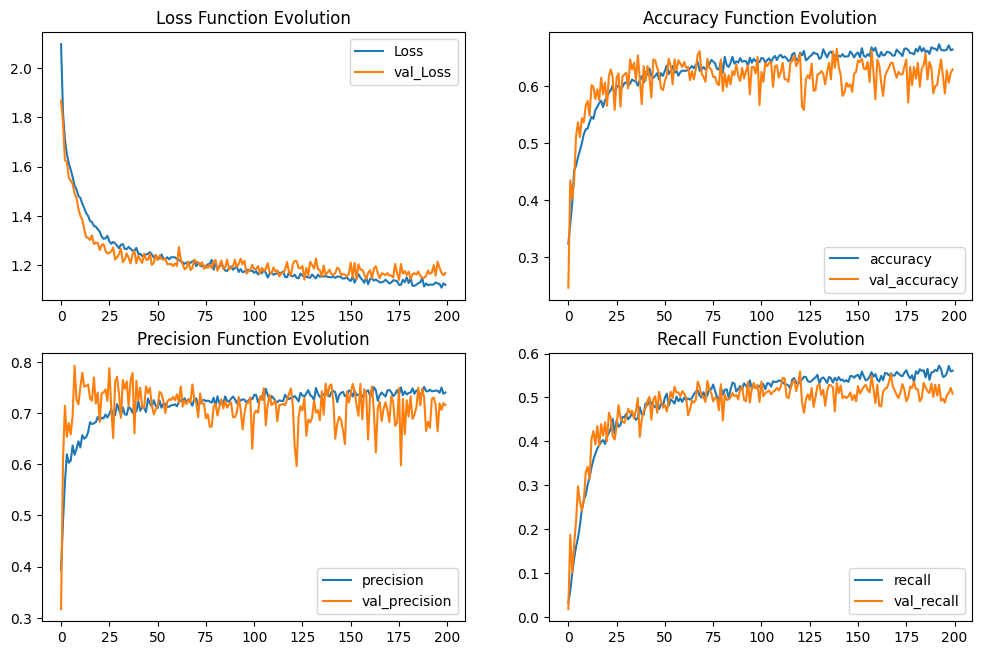

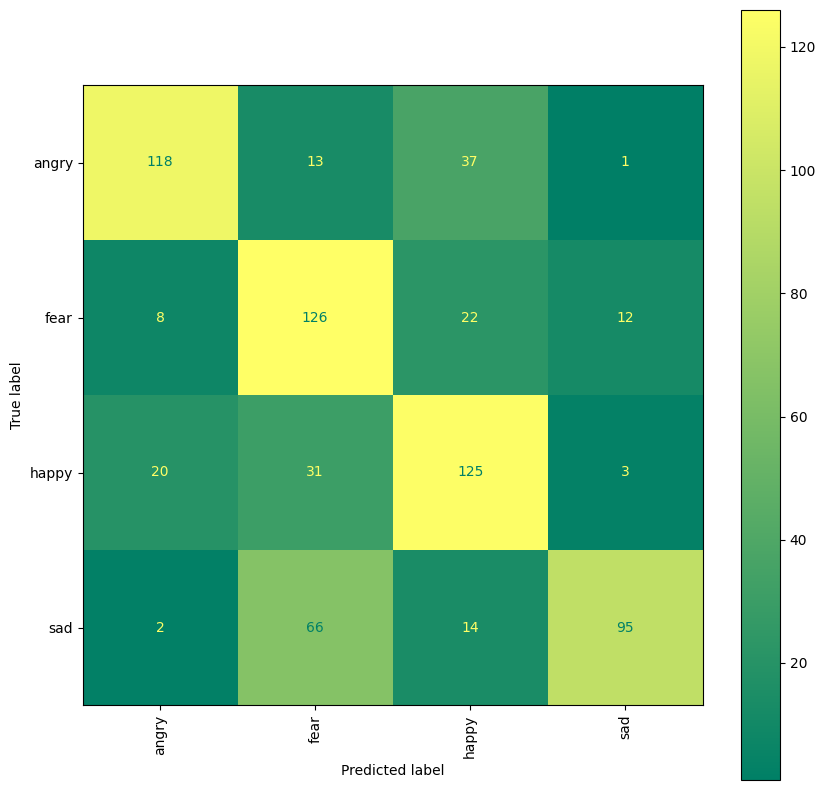

In [ ]:
plot_history(r_w)
display_conf(model_w,X_val, y_val)